In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import CalibrationDisplay

from ift6758.data import load_cached_seasons_dataframe, load_cached_season_dataframe

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import wandb

In [2]:
# on définit tous les models qu'on va entrainer dans ce notebook 
feature_sets = {
    "Distance": ["shotDistance"],
    "Angle": ["Angle"],
    "Distance+Angle": ["shotDistance", "shotAngle"],
}

## Séparation des ensembles d'entraînement et de validation

In [3]:
df_training = load_cached_seasons_dataframe(2016,2019) 
df_test = load_cached_season_dataframe(2020) # on y touche pas jusqu'à la fin

In [4]:
SHOT_LIKE = {"shot-on-goal", "goal", "missed-shot"}

def add_attack_sign(df,
                    x_col="x", team_col="teamShot",
                    game_col="gameId", period_col="period",
                    event_col="typeEvent"):
    ndf = df.copy()

    shots = ndf[
        ndf[event_col].isin(SHOT_LIKE)
        & ndf[x_col].notna()
    ].copy()

    attack = (
        shots.groupby([game_col, period_col, team_col])[x_col]
        .median()
        .gt(0)
        .astype(int)
        .replace({0: -1, 1: 1})
        .rename("attack_sign")
        .reset_index()
    )

    ndf = ndf.merge(attack, on=[game_col, period_col, team_col], how="left")

    ndf["attack_sign"] = (
        ndf.groupby([game_col, team_col])["attack_sign"]
        .transform(lambda s: s.ffill().bfill())
    )

    return ndf

In [5]:
def new_variables(df, goal_x=89.0, goal_y=0.0,
                  x_col="x", y_col="y",
                  event_col="typeEvent", empty_col="openNet"):
    ndf = add_attack_sign(df, x_col=x_col, team_col="teamShot",
                          game_col="gameId", period_col="period", event_col=event_col)

    ndf["x_adj"] = ndf[x_col] * ndf["attack_sign"]
    ndf["y_adj"] = ndf[y_col] * ndf["attack_sign"]

    dx = goal_x - ndf["x_adj"]
    dy = ndf["y_adj"] - goal_y

    ndf["shotDistance"] = np.sqrt(dx**2 + dy**2)
    ndf["shotAngle"] = np.degrees(np.arctan2(dy.abs(), dx))
    ndf["isGoal"] = ndf[event_col].astype(str).str.lower().eq("goal")
    ndf["isEmpty"] = ndf[empty_col].fillna(False).astype(int).eq(1)

    return ndf

df = new_variables(df_training)

In [6]:
X = df[["shotDistance"]].copy()
y = df["isGoal"].astype(int)

mask = X["shotDistance"].notna()
X = X.loc[mask]
y = y.loc[mask]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Régression Logistique sur la distance uniquement

## Entrainement du modèle

In [7]:
clf_dist = LogisticRegression()
clf_dist.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

## Précision et matrice de confusion

In [9]:
y_pred = clf_dist.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print("Accuracy (val):", acc)

print("Pred counts:", dict(zip(*np.unique(y_pred, return_counts=True))))
print("True counts:", dict(zip(*np.unique(y_val, return_counts=True))))

print("Confusion matrix:\n", confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred, digits=3))

Accuracy (val): 0.9060108454899565
Pred counts: {np.int64(0): np.int64(65465)}
True counts: {np.int64(0): np.int64(59312), np.int64(1): np.int64(6153)}
Confusion matrix:
 [[59312     0]
 [ 6153     0]]
              precision    recall  f1-score   support

           0      0.906     1.000     0.951     59312
           1      0.000     0.000     0.000      6153

    accuracy                          0.906     65465
   macro avg      0.453     0.500     0.475     65465
weighted avg      0.821     0.906     0.861     65465



C:\Users\pierr\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\pierr\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\pierr\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


# Régression Logistique sur l'angle uniquement

## Courbes ROC-AUC 

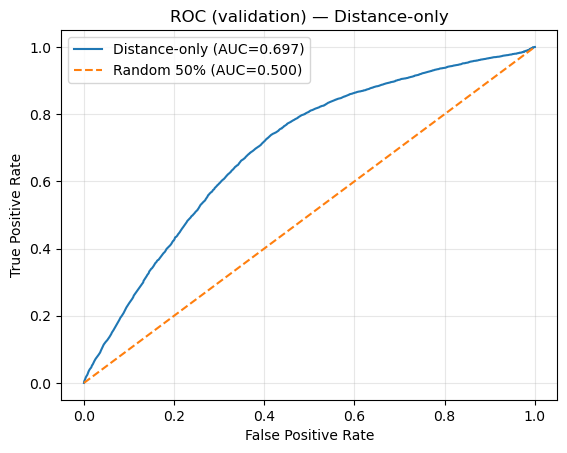

In [13]:
pos_idx = np.where(clf_dist.classes_ == 1)[0][0]
proba_val = clf_dist.predict_proba(X_val)[:, pos_idx]

false_positive_rate, true_positive_rate, _ = roc_curve(y_val, proba_val)
auc = roc_auc_score(y_val, proba_val)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, label=f"Distance-only (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random 50% (AUC=0.500)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (validation) — Distance-only")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


##  Le taux de buts en fonction du centile de la probabilité de tir donnée par le modèle

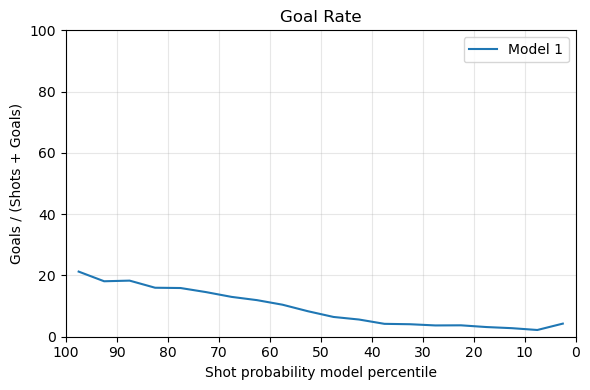

In [14]:
def goal_rate_by_percentile(y_true, proba_goal, step=5):
    validation_df = pd.DataFrame({
        "is_goal": np.asarray(y_true).astype(int),
        "proba_goal": np.asarray(proba_goal),
    })

    validation_df["percentile"] = validation_df["proba_goal"].rank(pct=True) * 100.0

    percentile_bins = np.arange(0, 100 + step, step)
    validation_df["percentile_bin"] = pd.cut(
        validation_df["percentile"],
        bins=percentile_bins,
        include_lowest=True,
        right=False
    )

    goal_rate_table = (
        validation_df
        .groupby("percentile_bin", observed=True)["is_goal"]
        .mean()
        .reset_index(name="goal_rate")
    )

    bin_midpoints = np.array([
        interval.left + step / 2
        for interval in goal_rate_table["percentile_bin"]
    ])

    return bin_midpoints, goal_rate_table["goal_rate"].to_numpy()

x_mid, goal_rate = goal_rate_by_percentile(y_val, proba_val, step=5)

goal_rate_percent = 100.0 * goal_rate # en %

plt.figure(figsize=(6, 4))
plt.plot(x_mid, goal_rate_percent, label="Model 1")
plt.title("Goal Rate")
plt.xlabel("Shot probability model percentile")
plt.ylabel("Goals / (Shots + Goals)")  # comme la figure du prof
plt.grid(alpha=0.3)
plt.xlim(100, 0) # Axe X: 100 -> 0 (inversé)
plt.xticks(np.arange(0, 101, 10))
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

## Proportion cumulée de but en fonction du centile de la probabilité de tir donnée par le modèle

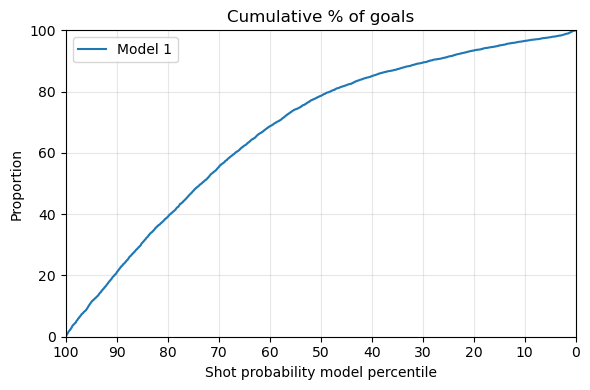

In [15]:
order = np.argsort(-proba_val)            # proba décroissante
y_sorted = np.asarray(y_val)[order].astype(int)

total_goals = y_sorted.sum()
cum_goals = np.cumsum(y_sorted)

if total_goals > 0:
    cum_prop_percent = 100.0 * (cum_goals / total_goals)   # 0..100 %
else:
    cum_prop_percent = np.zeros_like(cum_goals, dtype=float)

# % de tirs sélectionnés (top-k), puis converti en "percentile modèle" 100 -> 0
pct_shots_selected = (np.arange(1, len(y_sorted) + 1) / len(y_sorted)) * 100.0
shot_probability_percentile = 100.0 - pct_shots_selected   # ~100 -> 0

plt.figure(figsize=(6, 4))
plt.plot(shot_probability_percentile, cum_prop_percent, label="Model 1")
plt.title("Cumulative % of goals")
plt.xlabel("Shot probability model percentile")
plt.ylabel("Proportion")
plt.grid(alpha=0.3)
plt.xlim(100, 0)
plt.xticks(np.arange(0, 101, 10))
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

## Diagramme de fiabilité

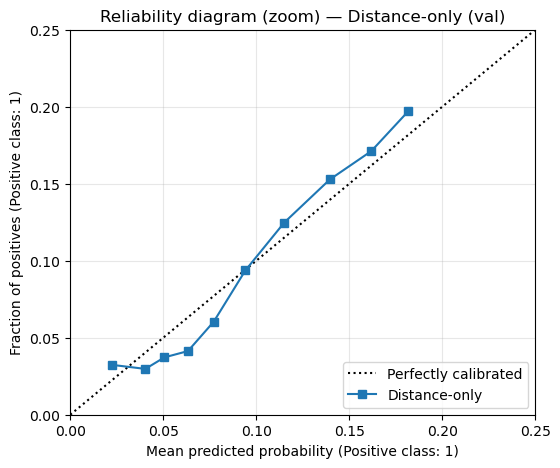

In [16]:
fig, ax = plt.subplots(figsize=(6,5))
CalibrationDisplay.from_predictions(
    y_val, proba_val,
    n_bins=10,
    strategy="quantile",
    name="Distance-only",
    ax=ax
)
ax.set_xlim(0, 0.25)
ax.set_ylim(0, 0.25)
ax.grid(alpha=0.3)
ax.set_title("Reliability diagram (zoom) — Distance-only (val)")
plt.show()

### Initialisation de Weights and Biaises

In [17]:
import os
import joblib

model_path = "models/lr_dist.joblib"
os.makedirs("models", exist_ok=True)

joblib.dump(clf_dist, model_path)
print("Saved to:", model_path)

Saved to: models/lr_dist.joblib


In [19]:
with wandb.init(project="Projet Hockey Emerano", entity="stefan-sucatu-polytechnique-montr-al") as run:

    run.log_model(path= model_path, name="lr_dist")

wandb: Currently logged in as: pierre-emery (stefan-sucatu-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
